# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "dateAdded" : "Date"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Date"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.16/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


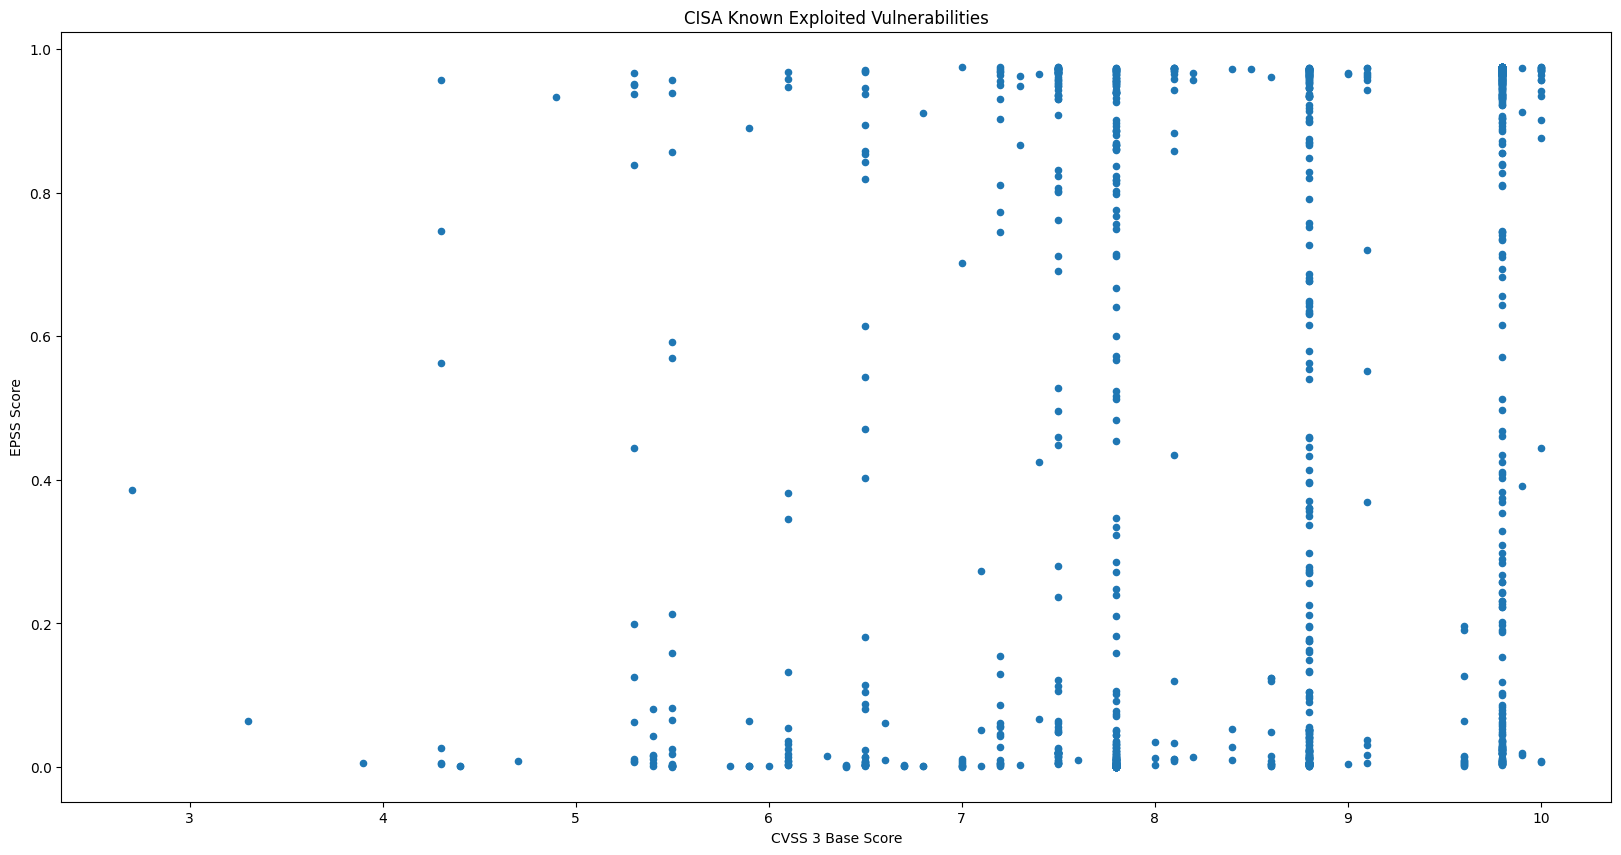

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CSV

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Date
0,CVE-2024-41710,NaN,0.00235,0.61592,"Mitel 6800 Series, 6900 Series, and 6900w Seri...",2025-02-12
1,CVE-2024-40891,8.8,0.04127,0.92172,Multiple Zyxel DSL CPE devices contain a post-...,2025-02-11
2,CVE-2024-40890,8.8,0.04127,0.92172,Multiple Zyxel DSL CPE devices contain a post-...,2025-02-11
3,CVE-2020-15069,9.8,0.07510,0.94154,Sophos XG Firewall contains a buffer overflow ...,2025-02-06
4,CVE-2020-29574,9.8,0.05315,0.93050,CyberoamOS (CROS) contains a SQL injection vul...,2025-02-06
5,CVE-2024-21413,9.8,0.02245,0.89408,Microsoft Outlook contains an improper input v...,2025-02-06
6,CVE-2022-23748,7.8,0.00294,0.69185,Dante Discovery contains a process control vul...,2025-02-06
7,CVE-2024-53104,7.8,0.00135,0.49828,Linux kernel contains an out-of-bounds write v...,2025-02-05
8,CVE-2018-19410,9.8,0.04906,0.92778,Paessler PRTG Network Monitor contains a local...,2025-02-04
9,CVE-2018-9276,7.2,0.81100,0.98621,Paessler PRTG Network Monitor contains an OS c...,2025-02-04
